In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from tqdm import tqdm
from censai import PhysicalModelv2
from censai.data.lenses_tng_v3 import decode_all, decode_train, decode_physical_model_info
from astropy.visualization import ImageNormalize, LogStretch
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.definitions import log_10
import tensorflow_probability as tfp

In [2]:
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_TNG100/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_noshift40k/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_NIE_10k/"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_k128_NIE_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses512_hk128_TNG100_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses128_hTNG100_10k_verydiffuse"
# datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_VAE_200k_control_validated_train/"
# datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_VAE_2M/"
datapath = "/home/aadam/scratch/Censai/data/lenses128hst_TNG_rau_200k_control_denoised"


files = glob.glob(os.path.join(datapath, "*.tfrecords"))
# files = [os.path.join(datapath, "data_10.tfrecords")]
files = tf.data.Dataset.from_tensor_slices(files)

dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"), block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
for physical_params in dataset.map(decode_physical_model_info):
    break
print(physical_params)
dataset = dataset.map(decode_all)

{'image fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'kappa fov': <tf.Tensor: shape=(), dtype=float32, numpy=7.6887193>, 'source fov': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'src pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'kappa pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>, 'pixels': <tf.Tensor: shape=(), dtype=int64, numpy=128>}


In [3]:

kappas = []
galaxies = []
lenses = []
noise_rms = []
psf = []
i = 0
for example in tqdm(dataset):
    kappas.append(example['kappa'])
    galaxies.append(example['source'])
    lenses.append(example['lens'])
    noise_rms.append(example["noise rms"].numpy())
    psf.append(example["psf"])
    i += 1
    if i == 200:
        break


199it [00:01, 119.86it/s]


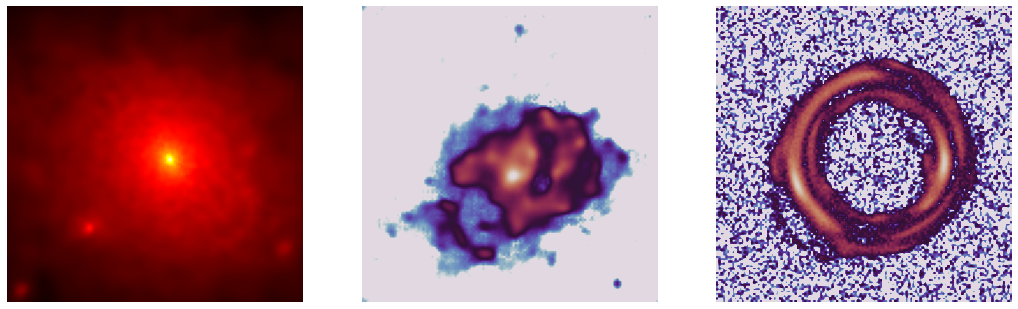

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
i = 103
axs[0].imshow(kappas[i][..., 0], cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[1].imshow(galaxies[i][..., 0], cmap="twilight", norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4, vmax=1))
axs[2].imshow(lenses[i][..., 0], cmap= "twilight",  norm=ImageNormalize(stretch=LogStretch(), vmin=1e-4, vmax=1))
for i in range(3):
    axs[i].axis("off")

In [5]:
kappa = kappas[i]
galaxy = galaxies[i]
lens = lenses[i]

In [6]:
import tensorflow_probability as tfp
from censai.definitions import DTYPE

tfd = tfp.distributions


class ImageFlow(tf.keras.Model):
    def __init__(self, flows, pixels, importance_samples=8):
        super(ImageFlow, self).__init__()
        self.flows = flows
        self.importance_samples = importance_samples
        self.prior = tfd.MultivariateNormalDiag(tf.zeros(shape=(pixels, pixels, 1)), tf.ones(shape=(pixels, pixels, 1)))
        self.pixels = pixels

    def forward(self, x):
        return self._get_likelihood(x)

    def encode(self, x):
        batch_size = x.shape[0]
        z, ldj = x, tf.zeros(shape=batch_size)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, x, return_ll=False):
        z, ldj = self.encode(x)  # return latent space vector z and
        log_pz = tf.reduce_sum(self.prior.log_prob(z), axis=(1, 2, 3))
        log_px = ldj + log_pz
        return log_px if return_ll else tf.reduce_mean(-log_px)

    def sample(self, batch_size, z_init=None, seed=None):
        if z_init is None:
            z = self.prior.sample(batch_size, seed)
        else:
            z = z_init
        ldj = tf.zeros(shape=batch_size)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def training_step(self, x):
        loss = self._get_likelihood(x)
        return loss

    def test_step(self, x):
        samples = []
        for _ in range(self.importance_samples):
            ll = self._get_likelihood(x, return_ll=True)
            samples.append(ll)
        ll = tf.stack(samples, axis=-1)

        ll = tf.math.reduce_logsumexp(ll, axis=-1) - tf.math.log(tf.cast(self.importance_samples, DTYPE))
        return tf.reduce_mean(-ll)


In [7]:

class ConcatELU(tf.keras.layers.Layer):
    def __init__(self):
        super(ConcatELU, self).__init__()

    def __call__(self, x):
        return tf.concat([tf.nn.elu(x), tf.nn.elu(-x)], axis=-1)


class GatedConv(tf.keras.layers.Layer):
    def __init__(self, c_in, c_hidden=-1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=c_hidden if c_hidden > 1 else 2*c_in,
            kernel_size=(3,3),
            padding="SAME",
            data_format="channels_last",
        )
        self.concat_elu = ConcatELU()
        self.conv2 = tf.keras.layers.Conv2D(
            filters=2 * c_in,
            kernel_size=(1,1),
            padding="SAME",
            data_format="channels_last",
        )

    def __call__(self, x):
        x = self.conv1(x)
        x = self.concat_elu(x)
        x = self.conv2(x)
        val, gate = tf.split(x, 2, axis=-1)
        return x + val * tf.nn.sigmoid(gate)

In [8]:
class SqueezeFlow(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.prior = tfd.Normal(loc=0.0, scale=1.0)

    def __call__(self, z, ldj, reverse=False):
        if reverse:
            z_split = self.prior.sample(sample_shape=z.shape)
            z = tf.concat([z, z_split], axis=-1)
            ldj -= tf.reduce_sum(self.prior.log_prob(z_split), axis=(1, 2, 3))
        else:
            z, z_split = tf.split(z, 2, axis=-1)
            ldj += tf.reduce_sum(self.prior.log_prob(z_split), axis=(1, 2, 3))
        return z, ldj

    
class SqueezeFlow(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def __call__(self, z, ldj, reverse=False):
        if reverse: # H/2 x W/2 x 4C ==> H x W x C
            z = tf.nn.depth_to_space(z, block_size=2)
        else: # H x W x C ==> H/2 x W/2 x 4C
            z = tf.nn.space_to_depth(z, block_size=2)
        return z, ldj


In [9]:


def checkerboard_mask(pixels, invert=False):
    x = tf.range(pixels, dtype=DTYPE)
    x, y = tf.meshgrid(x, x)
    mask = tf.math.floormod(x + y, 2)[tf.newaxis, tf.newaxis, ...]
    if invert:
        return 1 - mask
    else:
        return mask


def channel_mask(c_in, invert=False):
    mask = tf.concat([tf.ones(c_in//2, dtype=DTYPE), tf.zeros(c_in - c_in//2, dtype=DTYPE)])
    mask = mask[tf.newaxis, tf.newaxis, tf.newaxis, :]
    if invert:
        return 1 - mask
    else:
        return mask

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
from censai.definitions import DTYPE

tfd = tfp.distributions


class CouplingLayer(tf.keras.layers.Layer):
    def __init__(self, network, mask, c_in):
        super(CouplingLayer, self).__init__()
        self.network = network
        self.scaling_factor = tf.constant(c_in, DTYPE)[tf.newaxis, tf.newaxis, tf.newaxis, tf.newaxis]
        self.mask = tf.constant(mask, dtype=DTYPE)

    def __call__(self, z, ldj, reverse=False):
        return self.call(z, ldj, reverse)

    def call(self, z, ldj, reverse=False):
        z_in = z * self.mask
        nn_out = self.network(z_in)
        s, t = tf.split(nn_out, 2, axis=-1)

        # stabilize scaling output
        s_fac = tf.exp(self.scaling_factor)
        s = tf.nn.tanh(s / s_fac) * s_fac

        # mask outputs
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # affine transform
        if reverse:
            z = (z * tf.exp(-s)) - t
            ldj = ldj - tf.reduce_sum(s, axis=(1, 2, 3), keepdims=True)
        else:
            z = (z + t) * tf.exp(s)
            ldj = ldj + tf.reduce_sum(s, axis=(1, 2, 3), keepdims=True)
        return z, ldj


In [11]:
class GatedConvNet(tf.keras.Model):
    def __init__(self, c_in=1, c_hidden=-1, num_layers=3):
        super().__init__()
        layers = []
        layers += [GatedConv(c_in=1, c_hidden=c_hidden)]
        for i in range(num_layers):
            layers += [GatedConv(c_in=1, c_hidden=c_hidden), tf.keras.layers.LayerNormalization()]
        layers += [ConcatELU(), GatedConv(2*c_in)]
        self.call_layers = layers

    def __call__(self, x):
        for layer in self.call_layers:
            x = layer(x)
        return x

In [12]:
flows = [
    *[CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32, num_layers=2), mask=checkerboard_mask(pixels=128, invert=(i%2==1)), c_in=1) for i in range(20)]
]

# 2d Toy examples

In [13]:
tfb = tfp.bijectors

dims = 2

# A common choice for a normalizing flow is to use a Gaussian for the base
# distribution.  (However, any continuous distribution would work.) Here, we
# use `tfd.Sample` to create a joint Gaussian distribution with diagonal
# covariance for the base distribution (note that in the Gaussian case,
# `tfd.MultivariateNormalDiag` could also be used.)
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512, 512], activation=tf.nn.tanh)))

x = maf.sample()  # Expensive; uses `tf.while_loop`, no Bijector caching.
maf.log_prob(x)   # Almost free; uses Bijector caching.
# Cheap; no `tf.while_loop` despite no Bijector caching.
maf.log_prob(tf.zeros(dims))

# [Papamakarios et al. (2016)][3] also describe an Inverse Autoregressive
# Flow [(Kingma et al., 2016)][2]:
iaf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
    bijector=tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[20, 20]))))

x = iaf.sample()  # Cheap; no `tf.while_loop` despite no Bijector caching.
iaf.log_prob(x)   # Almost free; uses Bijector caching.
# Expensive; uses `tf.while_loop`, no Bijector caching.
iaf.log_prob(tf.zeros(dims))

# In many (if not most) cases the default `shift_and_log_scale_fn` will be a
# poor choice.  Here's an example of using a 'shift only' version and with a
# different number/depth of hidden layers.
made = tfb.AutoregressiveNetwork(params=1, hidden_units=[32])
maf_no_scale_hidden2 = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[dims]),
    bijector=tfb.MaskedAutoregressiveFlow(
        lambda y: (made(y)[..., 0], None),
        is_constant_jacobian=True))
maf_no_scale_hidden2._made = made  # Ensure maf_no_scale_hidden2.trainable
# NOTE: The last line ensures that maf_no_scale_hidden2.trainable_variables
# will include all variables from `made`.

In [91]:
"""
Author: He Sun
Modified 2021-11-08
Modified by Alexandre Adam
"""

logabs = lambda x: tf.math.log(tf.abs(x))

class ActNorm(tf.keras.layers.Layer):
    def __init__(self, logdet=True):
        super().__init__()

        self.loc = tf.Variable(tf.zeros(shape=(1,)))
        self.scale_inv = tf.Variable(tf.ones(shape=(1,)))
        self.logdet = logdet
        self.initialized = False

    def initialize(self, x, inv_init=False):
            mean = tf.reshape(tf.stop_gradient(tf.reduce_mean(x)), (1,))
            std = tf.reshape(tf.sqrt(tf.stop_gradient(tf.reduce_mean((x - mean)**2))), (1,))
            if inv_init:
                self.loc = tf.zeros_like(mean)
                self.scale_inv = tf.ones_like(std)
            else:
                self.loc = mean
                self.scale_inv = std + 1e-6
    
    def call(self, x, forward=True):
        if forward:
            return self.forward(x)
        else:
            return self.reverse(x)
        
#     @tf.function
    def forward(self, x):
        y = x
        if self.initialized is False:
            self.initialize(x)
            self.initialized = True
        
        _, in_dim = x.shape
        log_abs = -logabs(self.scale_inv)
        logdet = in_dim * tf.reduce_sum(log_abs)
        if self.logdet:
            return (1.0 / self.scale_inv) * (x + self.loc), logdet

        else:
            return (1.0 / self.scale_inv) * (x + self.loc)

#     @tf.function
    def reverse(self, x):
        if self.initialized is False:
            self.initialize(x, inv_init=True)
            self.initialized = True
            
        _, in_dim = x.shape
        log_abs = -logabs(self.scale_inv)
        logdet = -in_dim * tf.reduce_sum(log_abs)
        if self.logdet:
            return x * self.scale_inv - self.loc, logdet
        else:
            return x * self.scale_inv - self.loc



class ZeroFC(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()

        self.fc = tf.keras.layers.Dense(units, kernel_initializer=tf.zeros_initializer())
        self.scale = tf.Variable(tf.zeros(units))

    def call(self, x):
        out = self.fc(x)
        out = out * tf.exp(self.scale * 3)
        return out


class AffineCoupling(tf.keras.layers.Layer):
    def __init__(self, ndim, hidden_units=512, affine=True):
        super().__init__()
        self.affine = affine
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_units),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(epsilon=1e-2),
            tf.keras.layers.Dense(hidden_units),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.BatchNormalization(epsilon=1e-2),
            ZeroFC(ndim if self.affine else ndim//2),
        ]
        )
    
    def call(self, x, forward=True):
        if forward:
            return self.forward(x)
        else:
            return self.reverse(x)
        
    def forward(self, x):
        x_a, x_b = tf.split(x, 2, axis=-1)

        if self.affine:
            log_s, t = tf.split(self.net(x_b), 2, axis=-1)
            log_s = tf.nn.tanh(log_s)
            s = tf.exp(log_s)
            y_a = s * x_a + t
            y_b = x_b

            logdet = tf.reduce_sum(log_s, axis=1)

        else:
            net_out = self.net(x_b)
            y_a = x_a + net_out
            y_b = x_b
            logdet = None

        return tf.concat([y_a, y_b], -1), logdet

    def reverse(self, y):
        y_a, y_b = tf.split(y, 2, axis=-1)

        if self.affine:
            log_s, t = tf.split(self.net(y_b), 2, axis=-1)
            log_s = tf.nn.tanh(log_s)
            s = tf.exp(log_s)
            x_a = (y_a - t) / s
            x_b = y_b

            logdet = -tf.reduce_sum(log_s, axis=1)

        else:
            net_out = self.net(y_a)
            x_a = y_a - net_out
            x_b = y_b

            logdet = None

        return tf.concat([x_a, x_b], -1), logdet



class Flow(tf.keras.Model):
    def __init__(self, ndim, hidden_units=512, affine=True):
        super().__init__()

        self.actnorm = ActNorm()
        self.actnorm2 = ActNorm()
        self.coupling = AffineCoupling(ndim, hidden_units, affine=affine)
        self.coupling2 = AffineCoupling(ndim, hidden_units, affine=affine)

        self.ndim = ndim
    
    def call(self, x, forward=True):
        if forward:
            return self.forward(x)
        else:
            return self.reverse(x)

    def forward(self, x):
        logdet = 0
        out = x
        out, det1 = self.actnorm(x)
        out, det2 = self.coupling(out)
        out = tf.reverse(out, axis=(1,))
        out, det3 = self.actnorm2(out)
        out, det4 = self.coupling2(out)
        out = tf.reverse(out, axis=(1,))

        logdet = logdet + det1
        if det2 is not None:
            logdet = logdet + det2
        logdet = logdet + det3
        if det4 is not None:
            logdet = logdet + det4

        return out, logdet

    def reverse(self, z):
        logdet = 0
        z = tf.reverse(z, axis=(1,))
        z, det1 = self.coupling2.reverse(z)
        z, det2 = self.actnorm2.reverse(z)
        z = tf.reverse(z, axis=(1,))
        z, det3 = self.coupling.reverse(z)
        z, det4 = self.actnorm.reverse(z)


        if det1 is not None:
            logdet = logdet + det1
        logdet = logdet + det2
        if det3 is not None:
            logdet = logdet + det3
        logdet = logdet + det4

        return z, logdet
    
    
def Order_inverse(order):
    order_inv = []
    for k in range(len(order)):
        for i in range(len(order)):
            if order[i] == k:
                order_inv.append(i)
    return np.array(order_inv)

    
    
class RealNVP(tf.keras.Model):
    def __init__(
        self, ndim, n_flow, hidden_units, affine=True,  permute='no_permutation'):
        super().__init__()
        self.blocks = []
        self.orders = []
        for i in range(n_flow):
            self.blocks.append(Flow(ndim, hidden_units=hidden_units[i], affine=affine))
            if permute == 'random':
                self.orders.append(np.random.RandomState(seed=i).permutation(ndim))
            elif permute == 'reverse':
                self.orders.append(np.arange(ndim-1, -1, -1))
            else:
                self.orders.append(np.arange(ndim))

        self.inverse_orders = []
        for i in range(n_flow):
            self.inverse_orders.append(Order_inverse(self.orders[i]))
            
    def call(self, x, forward=True):
        if forward:
            return self.forward(x)
        else:
            return self.reverse(x)
        
    def forward(self, x):
        logdet = 0
        out = x

        for i in range(len(self.blocks)):
            out, det = self.blocks[i](out)
            logdet = logdet + det
            out = tf.gather(out, self.orders[i], axis=1)

        return out, logdet

    def reverse(self, out):
        logdet = 0
        x = out

        for i in range(len(self.blocks)-1, -1, -1):
            x = tf.gather(x, self.inverse_orders[i], axis=1)
            x, det = self.blocks[i].reverse(x)
            logdet = logdet + det

        return x, logdet
    
    def sample(self, n_samples):
        z = tf.random.normal(shape=(n_samples, 2))
        x, _ = self.reverse(z)
        return x
    
    def log_prob(self, x, return_logdet=True):
        z, logdet = self.forward(x)
        if return_logdet:
            return - 0.5 * (z[:, 0]**2 + z[:, 1]**2) - 0.5 * np.log(2 * np.pi), logdet
        else:
            return - 0.5 * (z[:, 0]**2 + z[:, 1]**2) - 0.5 * np.log(2 * np.pi)
    

In [92]:
# class NPVNode(tf.keras.Model):
#     def __init__(self):
#         super(NPVNode, self).__init__()
#         self.scale = tf.keras.layers.Dense(1)  # Scale is Ax + b, i.e. affine transformation

#         self.g_theta_scale = tf.keras.Sequential([
#             tf.keras.layers.Dense(32), 
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dense(32),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dense(1)
#         ]
#         )

#         self.g_theta_shift =  tf.keras.Sequential([
#             tf.keras.layers.Dense(32), 
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dense(32),
#             tf.keras.layers.LeakyReLU(),
#             tf.keras.layers.Dense(1)
#         ]
#         )
        
#     def call(self, x, forward=True):
#         if forward:
#             return self.forward(x)
#         else:
#             return self.reverse(x)
        
#     def forward(self, x):
#         logdet = 0
#         out = x

#         for i in range(len(self.blocks)):
#             out, det = self.blocks[i](out)
#             logdet = logdet + det
#             out = tf.gather(out, self.orders[i], axis=1)

#         return out, logdet

#     def reverse(self, out):
#         logdet = 0
#         x = out

#         for i in range(len(self.blocks)-1, -1, -1):
#             x = tf.gather(x, self.inverse_orders[i], axis=1)
#             x, det = self.blocks[i].reverse(x)
#             logdet = logdet + det

#         return x, logdet

#     def call(self, x1, x2, logdet):
#         x1, x2 = x2, x1 # reverse order

#         z1 = x1
#         log_scale = self.scale(tf.nn.tanh(self.g_theta_scale(x1)))
#         z2 = tf.exp(log_scale) * x2 + self.g_theta_shift(x1)

#         logdet = log_scale + logdet
#         return z1, z2, logdet


# class RealNVP(tf.keras.Model):
#     def __init__(self, num_layers=15):
#         super(RealNVP, self).__init__()
#         modules = [NPVNode() for _ in range(num_layers)]
#         self.net = nn.Sequential(*modules)

#     def call(self, x):
#         z1, z2 = x[:, [1]], x[:, [0]]
#         logdet = tf.zeros(shape=(1,))
#         for layer in self.net:
#             z1, z2, logdet = layer(z1, z2, logdet)

#         return tf.concat([z1, z2], axis=1), logdet


In [93]:
realnvp =  RealNVP(2, n_flow=16, hidden_units=[128]*16, affine=True)
realnvp.call(tf.random.normal(shape=[512, 2]), forward=False);

TypeError: unsupported operand type(s) for *: 'Dense' and 'int'

In [89]:
###############################################################################
# Three examples of 2D toy loglikelihood
###############################################################################
# Example 1 - Gaussian mixture
x1, y1, a1, sigma1 = -0.5, -0.5, 1, 0.4
x2, y2, a2, sigma2 = -0.5, 0.5, 1, 0.4
x3, y3, a3, sigma3 = 0.5, -0.5, 1, 0.4
x4, y4, a4, sigma4 = 0.5, 0.5, 1, 0.4
log_prob1 = lambda x, y: tf.math.log(a1 * tf.math.exp(-1/sigma1**2*((x-x1)**2+(y-y1)**2)) + \
						a2 * tf.math.exp(-1/sigma2**2*((x-x2)**2+(y-y2)**2)) + \
						a3 * tf.math.exp(-1/sigma3**2*((x-x3)**2+(y-y3)**2)) + \
						a4 * tf.math.exp(-1/sigma4**2*((x-x4)**2+(y-y4)**2)))

# Example 2 - double crescent
log_prob2 = lambda x, y: -0.5 * ((tf.sqrt((4*x)**2 + (4*y)**2)-2)/0.6)**2 + \
						tf.math.log(tf.math.exp(-0.5 * (4*x-2)**2/0.6**2)+tf.math.exp(-0.5 * (4*x+2)**2/0.6**2))

# Example 3 - sinusoidal
log_prob3 = lambda x, y: -0.5 * ((4*y - tf.math.sin(2*np.pi*x))/0.4)**2

In [98]:
optimizer = tf.keras.optimizers.RMSprop(lr=1e-5)
flow = realnvp
loss = lambda x, y: -log_prob2(x, y)

n_epoch = 1500
n_samples = 512

for k in tqdm(range(n_epoch)):
    with tf.GradientTape() as tape:
        tape.watch(flow.trainable_variables)
        x_sampled, logdet = flow.reverse(tf.random.normal(shape=(n_samples, 2)))
        det_sigmoid = tf.reduce_sum(-x_sampled - 2 * tf.nn.softplus(-x_sampled), axis=-1)
        logdet = logdet + det_sigmoid
        x_sampled = 2 * tf.nn.sigmoid(x_sampled) - 1
        cost = tf.reduce_mean(loss(x_sampled[:, 1], x_sampled[:, 0]) - logdet)
    grads = tape.gradient(cost, flow.trainable_variables)
    grads = [tf.clip_by_norm(grad, 4.) for grad in grads]
    optimizer.apply_gradients(zip(grads, flow.trainable_variables))
    if k % 50 == 0:
        print(f"epoch {k}: cost {cost.numpy():.2e}")

  0%|          | 1/1500 [00:00<13:51,  1.80it/s]

epoch 0: cost 6.07e+00


  3%|▎         | 51/1500 [00:22<10:16,  2.35it/s]

epoch 50: cost 5.89e+00


  7%|▋         | 101/1500 [00:43<09:57,  2.34it/s]

epoch 100: cost 5.79e+00


 10%|█         | 151/1500 [01:05<09:43,  2.31it/s]

epoch 150: cost 6.05e+00


 13%|█▎        | 201/1500 [01:26<09:12,  2.35it/s]

epoch 200: cost 6.00e+00


 17%|█▋        | 251/1500 [01:47<08:53,  2.34it/s]

epoch 250: cost 5.79e+00


 20%|██        | 301/1500 [02:09<08:35,  2.33it/s]

epoch 300: cost 5.91e+00


 23%|██▎       | 351/1500 [02:31<08:11,  2.34it/s]

epoch 350: cost 5.93e+00


 27%|██▋       | 401/1500 [02:52<07:47,  2.35it/s]

epoch 400: cost 5.96e+00


 30%|███       | 451/1500 [03:14<07:25,  2.36it/s]

epoch 450: cost 5.96e+00


 33%|███▎      | 501/1500 [03:35<07:44,  2.15it/s]

epoch 500: cost 5.72e+00


 37%|███▋      | 551/1500 [03:57<06:44,  2.34it/s]

epoch 550: cost 5.84e+00


 40%|████      | 601/1500 [04:18<06:21,  2.36it/s]

epoch 600: cost 6.02e+00


 43%|████▎     | 651/1500 [04:40<06:02,  2.34it/s]

epoch 650: cost 5.89e+00


 47%|████▋     | 701/1500 [05:01<05:38,  2.36it/s]

epoch 700: cost 5.94e+00


 50%|█████     | 751/1500 [05:23<05:16,  2.37it/s]

epoch 750: cost 5.87e+00


 51%|█████     | 759/1500 [05:26<05:18,  2.32it/s]


KeyboardInterrupt: 

In [ ]:
x_sampled = flow.sample(512)
x_sampled = 2 * tf.nn.sigmoid(x_sampled) - 1
plt.plot(x_sampled[:, 0], x_sampled[:, 1], 'rx')

In [ ]:



x_range = np.arange(-0.95, 0.95, 0.05)
y_range = np.arange(-0.95, 0.95, 0.05)

X, Y = np.meshgrid(x_range, y_range)
value = loss(X, Y)
Z = np.array(value)

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 
prob_true = np.exp(-Z) / np.sum(np.exp(-Z))
cp = plt.contourf(X, Y, prob_true, 40)
cp = plt.contour
cp = plt.colorbar()


In [ ]:
XY = tf.cast(tf.stack([X.ravel(), Y.ravel()], axis=-1), tf.float32)
XY = tf.math.log(1 + XY + 1e-8) - tf.math.log(1 - XY + 1e-8)
logprob, logdet = flow.log_prob(XY)
det_sigmoid = tf.reduce_sum(XY + 2 * tf.nn.softplus(-XY), axis=-1)
logdet = logdet + det_sigmoid
logprob = tf.reshape(logprob + logdet, X.shape)

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

prob = np.exp(logprob) / np.sum(np.exp(logprob))
# prob = logprob
cp = plt.contourf(Y, X, prob, 40)
cp = plt.colorbar()